# Compsci 571 HW5
## Question 3 Ridge Regression

## 3b) MSE for $\beta_1$ and $\beta_2$ under different $\lambda$ values

In [44]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn import metrics

In [12]:
X = scipy.io.loadmat('X.mat')
X = X['X'] # take out the real useful matrix (I hate matlab!)

In [14]:
print('Shape of X is:', X.shape)

Shape of X is: (50, 20)


So the X matrix contains 50 observations, and each observation has 20 features.

In [40]:
def generate_y(X, beta):
    assert X.shape[1] == beta.shape[0]
    n = X.shape[0]
    p = X.shape[1]
    e = np.random.normal(0, 1.0, n)
    e = e.reshape(n, 1)
#     plt.hist(e)
#     plt.show()
    y = np.dot(X, beta) + e
    return y

In [27]:
beta1 = np.array([0.1, 0.3, 0.2, 0.2, 0.9, 0.8, 0.9, 0.1, 0.4, 0.2, 0.7, \
                 0.3, 0.1, 0.7, 0.8, 0.3, 0.2, 0.8, 0.1, 0.7]).reshape(20, 1)
beta2 = np.array([0.5, 0.6, 0.7, 0.9, 0.9, 0.8, 0.9, 0.8, 0.6, 0.5, 0.7, \
                 0.6, 0.7, 0.7, 0.8, 0.8, 0.9, 0.8, 0.5, 0.7]).reshape(20, 1)
print(beta1.shape)
print(beta2.shape)

(20, 1)
(20, 1)


In [46]:
def ridge_mse(X, beta, lambda_value, t = 100):
    mse = 0.0
    ridge = Ridge(alpha = lambda_value)
    for i in range(t):
        y = generate_y(X, beta)
        assert X.shape[0] == y.shape[0]
        assert y.shape[1] == 1
        ridge.fit(X, y)
        yhat = ridge.predict(X)
        mse = mse + metrics.mean_squared_error(y, yhat)
    mse = mse / t
    return mse

In [50]:
mse_beta1 = []
mse_beta2 = []
for l in np.arange(0.0, 10, 0.1): # loop over different lambda values
    mse1 = ridge_mse(X, beta1, l)
    mse2 = ridge_mse(X, beta2, l)
    mse_beta1.append(mse1)
    mse_beta2.append(mse2)

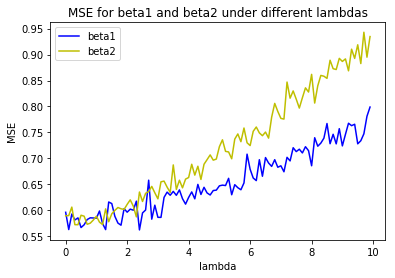

In [54]:
plt.plot(np.arange(0.0, 10, 0.1), mse_beta1, c = 'b', label = 'beta1')
plt.plot(np.arange(0.0, 10, 0.1), mse_beta2, c = 'y', label = 'beta2')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('MSE')
plt.title('MSE for beta1 and beta2 under different lambdas')
plt.show()